# Randon Forest Model wwith TF-IDF and Bag of words

In [1]:
# file path exist


import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string

# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.ensemble import RandomForestClassifier

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [2]:
filename  = '../Data/Real and fake news/news'
df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.drop(df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
df = df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [3]:
# Run only for English data 
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)
data = df

In [4]:
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [5]:
# Same sentence after translation
data.text[3]

"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People For Bernie (@People4Bernie) November 9, 2016 If Dems didn't want a tight race they shouldn't have worked against Bernie. \n— Walker Bragman (@WalkerBragman) November 9, 2016 \nNew York Times columnist Paul Krugman, who was one of Hillary Clinton’s most outspoken surrogates during the contentious Democratic primary, blamed Clinton’s poor performance on Green Party candidate Jill Stein, who has so far received a negligible number of votes nationally, saying Stein was the Ralph Nader of 2016 in preventing a Clinton victory. The account @BerniesTeachers threw Krugman’s analysis back in his face. Your candidate was the issue. Take responsibility. https://t.co/KHyOuUSrFS \n— Teachers for Bernie (@BerniesTeachers) November 9, 2016 \nAna Navarro, a Republican who recently endorsed Hillary Clinton, sum

### Class count

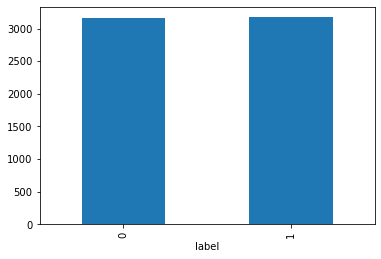

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [7]:
# For entire dataset sentences for each labels 
data.label.value_counts()

1    3171
0    3164
Name: label, dtype: int64

In [8]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [9]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [10]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

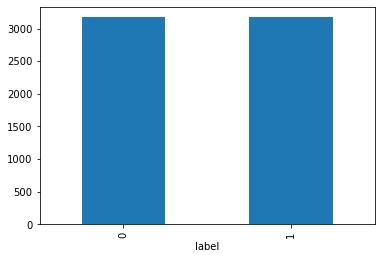

In [11]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [12]:
data.label.value_counts()

1    3171
0    3170
Name: label, dtype: int64

In [13]:
data=data.sample(frac=1).reset_index(drop=True)
data

,text,label
0,The latest batch of emails released by WikiLea...,1
1,0 comments \nWith just 10 days to go before th...,0
2,"On Wednesday night, stories started pouring in...",1
3,Orangutan. \nRigged. Worth trying but its not ...,0
4,Rush Limbaugh: “I don’t remember a vice presid...,1
...,...,...
6336,"in: Politics , Sleuth Journal , Special Intere...",0
6337,Videos Evidence Reveals Possible Link Between ...,0
6338,"in: Special Interests , US News The new year i...",0
6339,These Jellyfish Lodges are capable of purifyin...,0


### Data Preprocessing

In [14]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [15]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [16]:
data.shape

(6341, 2)

In [17]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.text]

In [18]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [19]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [20]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [21]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [22]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [23]:
zero  = []
one = []

for l in data.label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'label', '0', '1']]

In [24]:
category_id = []
for l in data.label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'label', '0', '1', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,label,0,1,Category_id
0,latest batch email released wikileaks provides...,"[latest, batch, email, released, wikileaks, pr...",1,0,1,1
1,0 comment 10 day go important election lifetim...,"[0, comment, 10, day, go, important, election,...",0,1,0,0
2,wednesday night story started pouring woman ac...,"[wednesday, night, story, started, pouring, wo...",1,0,1,1
3,orangutan rigged worth trying fair game smartm...,"[orangutan, rigged, worth, trying, fair, game,...",0,1,0,0
4,rush limbaugh : “ ’ remember vice presidential...,"[rush, limbaugh, :, “, ’, remember, vice, pres...",1,0,1,1
5,late last week u department agriculture ( usda...,"[late, last, week, u, department, agriculture,...",0,1,0,0
6,puerto rico default $ 422 - million debt payme...,"[puerto, rico, default, $, 422, -, million, de...",1,0,1,1
7,russian state medium reported many 217 passeng...,"[russian, state, medium, reported, many, 217, ...",1,0,1,1
8,texas attorney general ken paxton along attorn...,"[texas, attorney, general, ken, paxton, along,...",1,0,1,1
9,thousand descended washington last week annual...,"[thousand, descended, washington, last, week, ...",1,0,1,1


In [25]:
# Removing empty rows after tokenization

In [26]:
data = data[data.tokens != '']

In [27]:
from io import StringIO
category_id_df = data[['label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# RFM - TFIDF

In [28]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.label
features.shape

(6341, 489691)

In [29]:
data.label.value_counts()

1    3171
0    3170
Name: label, dtype: int64

In [30]:
# Spliting data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10,shuffle = True, random_state=42)

In [31]:
# Generate model
model1 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=32)
clf = model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

### RFM - Displaying false-positive rate (FPR) and true positive rate (TPR)

Random Forest Method


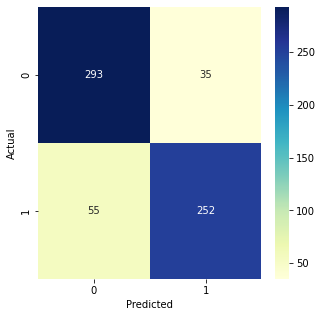

In [33]:
# confusion matrix
print("Random Forest Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap ='YlGnBu',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [34]:
results1 = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[293  35]
 [ 55 252]]
Accuracy Score : 0.8582677165354331
Report : 
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       328
           1       0.88      0.82      0.85       307

    accuracy                           0.86       635
   macro avg       0.86      0.86      0.86       635
weighted avg       0.86      0.86      0.86       635



# RFM - BOW

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features3 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.label
features3.shape

(6341, 61326)

In [37]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features3, labels, data.index, test_size=0.10, shuffle = True, random_state=42)

In [38]:
model3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)
clf3 = model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

###  RFM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     RFM - BOW


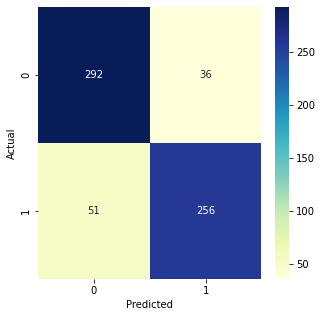

In [41]:
from sklearn.metrics import confusion_matrix
print("                     RFM - BOW")
conf_mat = confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [42]:
results3 = confusion_matrix(y_test, y_pred3)
print ('Confusion Matrix :')
print(results3) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred3))
print ('Report : ')
print (classification_report(y_test, y_pred3))

Confusion Matrix :
[[292  36]
 [ 51 256]]
Accuracy Score : 0.862992125984252
Report : 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       328
           1       0.88      0.83      0.85       307

    accuracy                           0.86       635
   macro avg       0.86      0.86      0.86       635
weighted avg       0.86      0.86      0.86       635



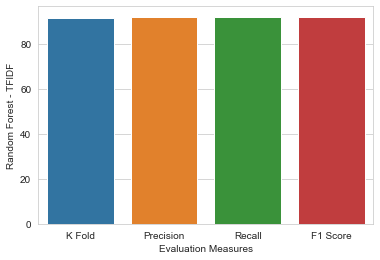

In [43]:
# for tfidf
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Random Forest - TFIDF']=[91.4, 92, 92, 92]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Random Forest - TFIDF',data=results)

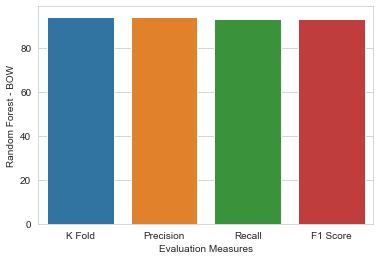

In [44]:
# for BOW
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Random Forest - BOW']=[94.1, 94, 93, 93]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Random Forest - BOW',data=results)